In [1]:
import cv2
import numpy as np
import os
import glob
import pandas as pd
from scipy.spatial import distance
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import warnings

asset_dir = "../Assets/hu_moments/"

In [2]:
def create_variants(image_path, output_dir=asset_dir+"variants", target_size=(512, 512)):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Could not read image: {image_path}")
        return []
    
    # PREPROCESSING: Resize to target size (512x512)
    img = cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR)

    base_name = os.path.splitext(os.path.basename(image_path))[0]
    variants = {'original': img}

    # 1. Scaling (Half Size)
    variants['scaled_0.5x'] = cv2.resize(img, (0, 0), fx=0.5, fy=0.5)

    # 2. Rotation (30 degrees)
    rows, cols = img.shape
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), 30, 1)
    variants['rotated_30deg'] = cv2.warpAffine(img, M, (cols, rows))

    # 3. Mirroring (Horizontal Flip)
    variants['mirrored'] = cv2.flip(img, 1)

    # 4. Brightness Increase
    variants['brighter'] = np.clip(img.astype(int) + 50, 0, 255).astype(np.uint8)

    # 5. Rotation (90 degrees)
    variants['rotated_90deg'] = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)

    # Save and return paths
    saved_files = {}
    for key, var_img in variants.items():
        filename = os.path.join(output_dir, f"{base_name}_{key}.png")
        cv2.imwrite(filename, var_img)
        saved_files[f"{base_name}_{key}"] = filename
        
    return saved_files

def visualize_variants(variants_dict, base_name):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f'Image Variants for {base_name}', fontsize=16, fontweight='bold')
    
    variant_names = ['original', 'scaled_0.5x', 'rotated_30deg', 'mirrored', 'brighter', 'rotated_90deg']
    
    for i, variant_name in enumerate(variant_names):
        row, col = i // 3, i % 3
        
        matching_key = None
        for key in variants_dict.keys():
            if variant_name in key and base_name in key:
                matching_key = key
                break
        
        if matching_key:
            img = cv2.imread(variants_dict[matching_key], cv2.IMREAD_GRAYSCALE)
            axes[row, col].imshow(img, cmap='gray')
            axes[row, col].set_title(variant_name.replace('_', ' ').title(), fontweight='bold')
            axes[row, col].axis('off')
        else:
            axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

In [3]:
def calculate_hu_moments(image_path, use_adaptive=False):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Threshold the image to focus on shape
    # if use_adaptive:
    #     img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    #                                 cv2.THRESH_BINARY, 11, 2)
    # else:
    #     _, img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
    
    moments = cv2.moments(img)
    hu_moments = cv2.HuMoments(moments)
    
    with np.errstate(divide='ignore', invalid='ignore'):
      log_hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments))
      log_hu_moments[np.isinf(log_hu_moments)] = 0
      log_hu_moments[np.isnan(log_hu_moments)] = 0
      
    return log_hu_moments.flatten()[:4] # Return first 4 moments

In [4]:
def chi_squared_distance(vec1, vec2, eps=1e-10):
    return 0.5 * np.sum([((a - b) ** 2) / (a + b + eps) for (a,b) in zip(vec1, vec2)])

In [5]:
image_dir = asset_dir + "base"
base_image_paths = glob.glob(os.path.join(image_dir, '*.*'))[:4]

for path in base_image_paths:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

all_variants = {}
for path in base_image_paths:
    variants = create_variants(path)
    all_variants.update(variants)

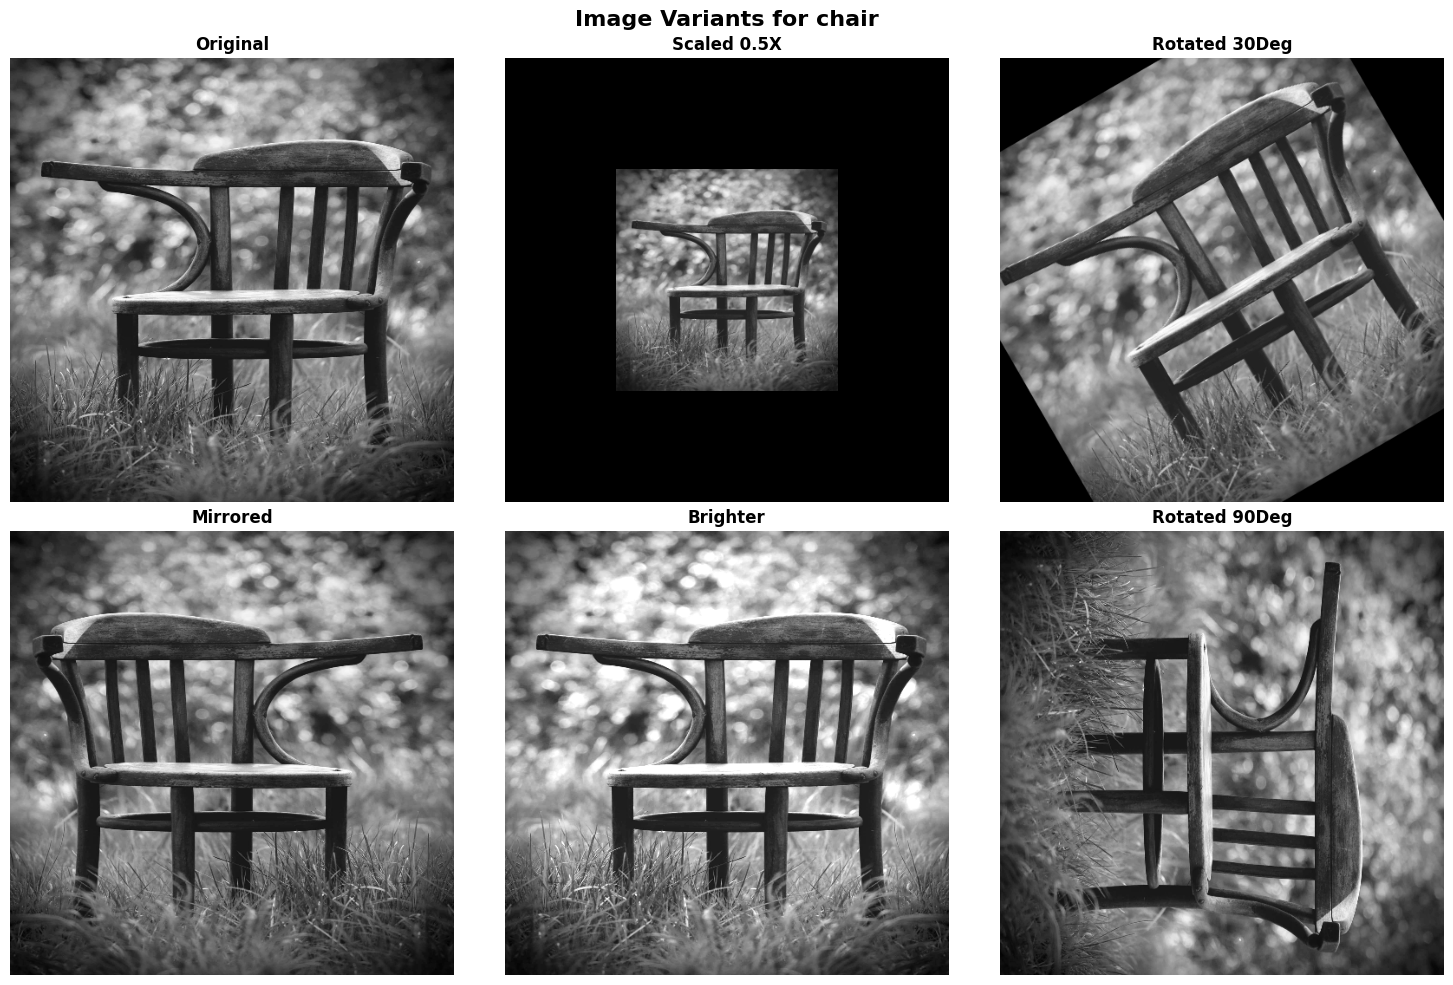

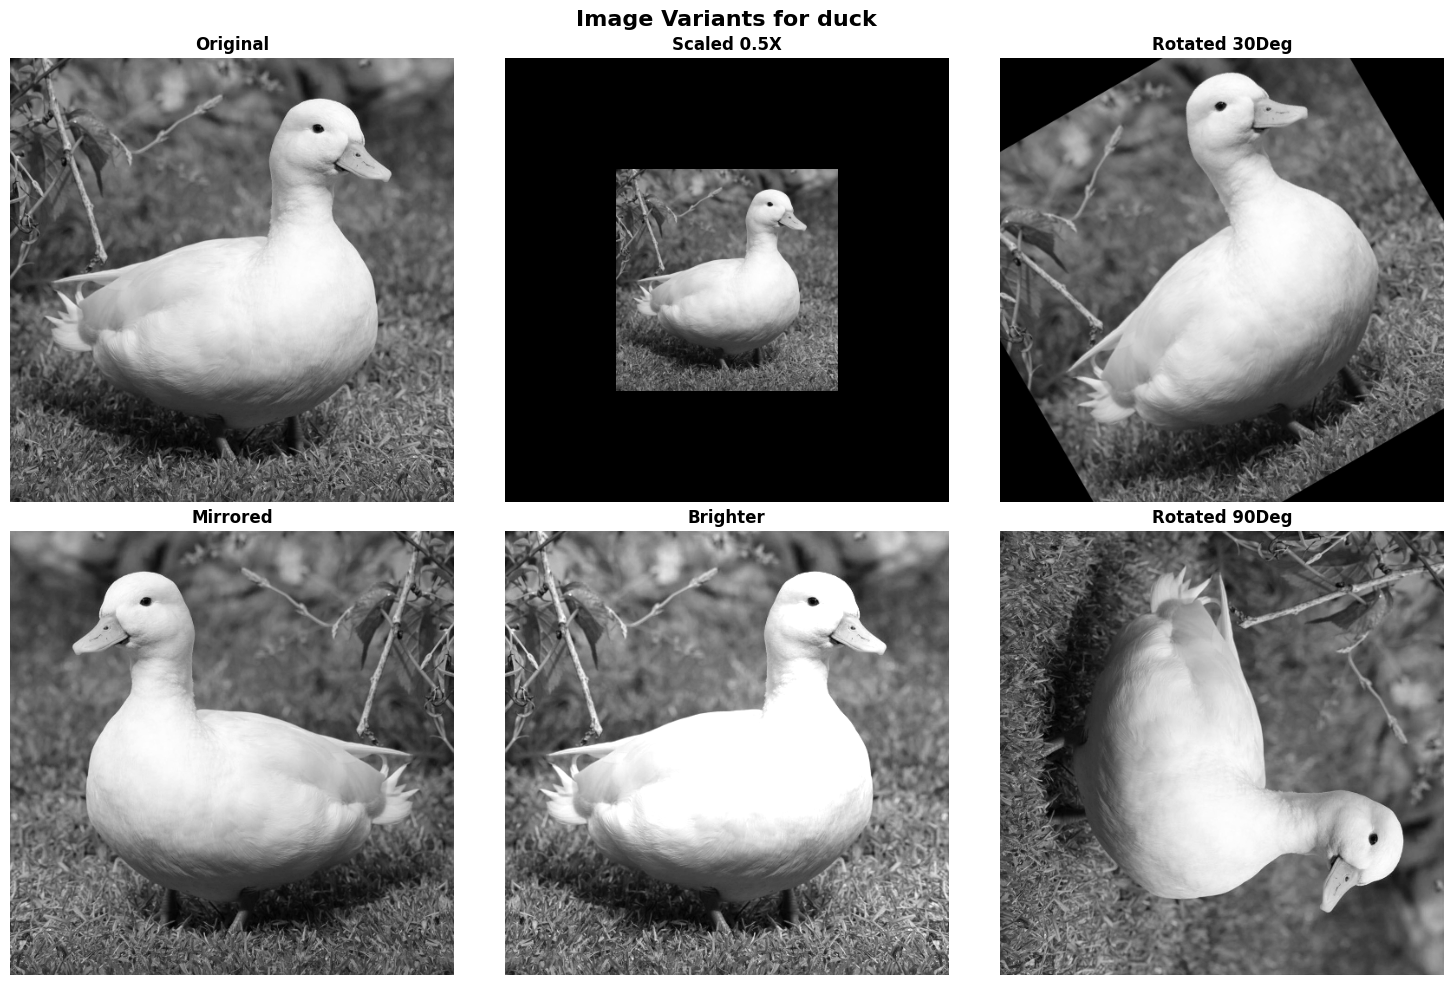

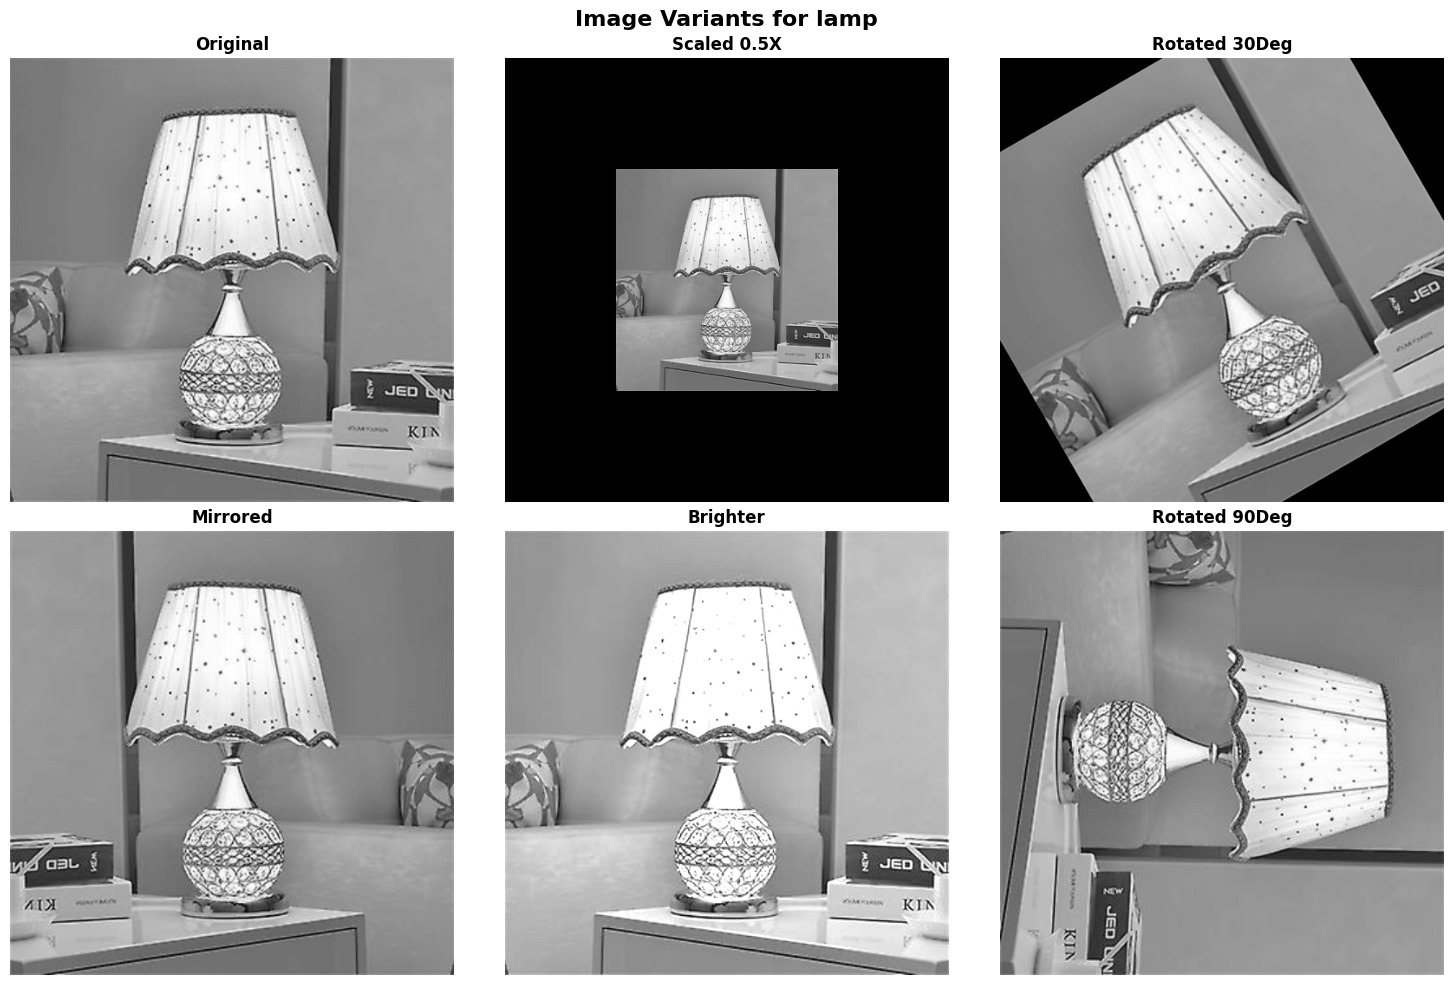

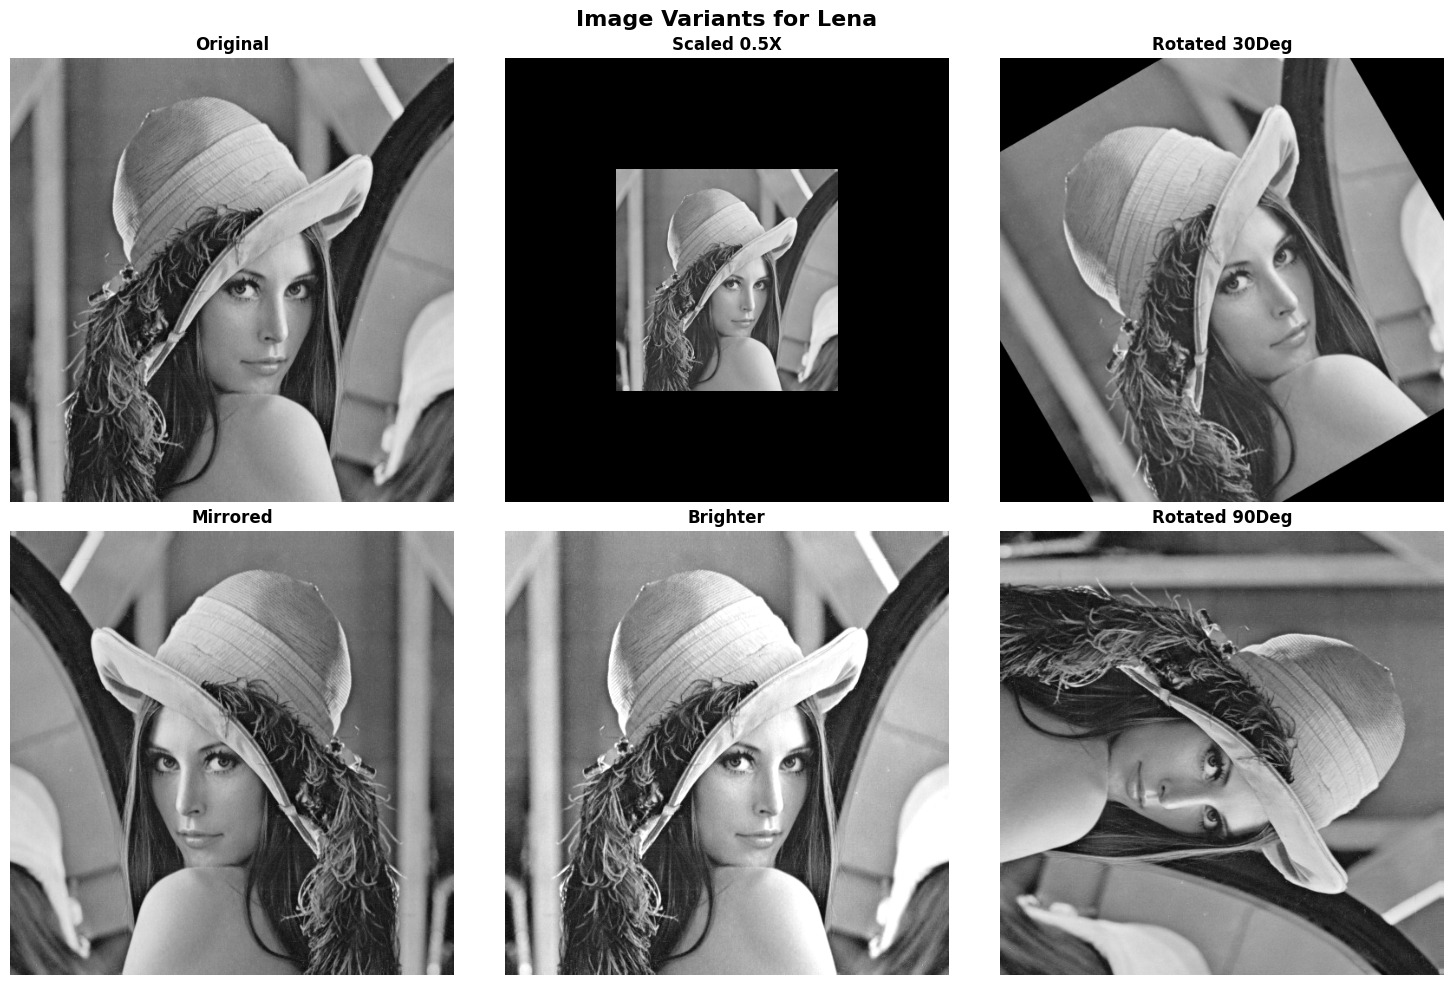

In [6]:
def visualize_variants(image_path, variants_dict):
    base_name = os.path.splitext(os.path.basename(image_path))[0].replace('_patch', '')

    variant_names = ['original', 'scaled_0.5x', 'rotated_30deg', 'mirrored', 'brighter', 'rotated_90deg']
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f'Image Variants for {base_name}', fontsize=16, fontweight='bold')
    
    for i, variant_name in enumerate(variant_names):
        row, col = i // 3, i % 3
        
        matching_key = None
        for key in variants_dict.keys():
            if variant_name in key and base_name in key:
                matching_key = key
                break
        
        if matching_key:
            img = cv2.imread(variants_dict[matching_key], cv2.IMREAD_GRAYSCALE)
            
            if 'scaled' in variant_name:
                orig_key = None
                for key in variants_dict.keys():
                    if 'original' in key and base_name in key:
                        orig_key = key
                        break
                
                if orig_key:
                    orig_img = cv2.imread(variants_dict[orig_key], cv2.IMREAD_GRAYSCALE)
                    orig_h, orig_w = orig_img.shape
                    
                    canvas = np.zeros((orig_h, orig_w), dtype=np.uint8)
                    
                    h, w = img.shape
                    y_offset = (orig_h - h) // 2
                    x_offset = (orig_w - w) // 2
                    
                    canvas[y_offset:y_offset+h, x_offset:x_offset+w] = img
                    img = canvas
            
            axes[row, col].imshow(img, cmap='gray')
            axes[row, col].set_title(variant_name.replace('_', ' ').title(), fontweight='bold')
            axes[row, col].axis('off')
        else:
            axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

for path in base_image_paths:
    visualize_variants(path, all_variants)


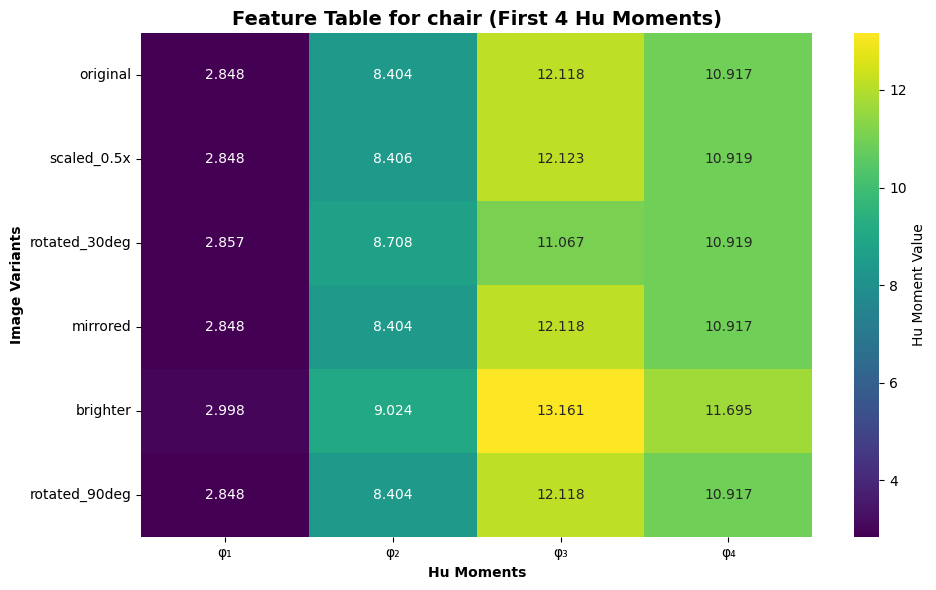

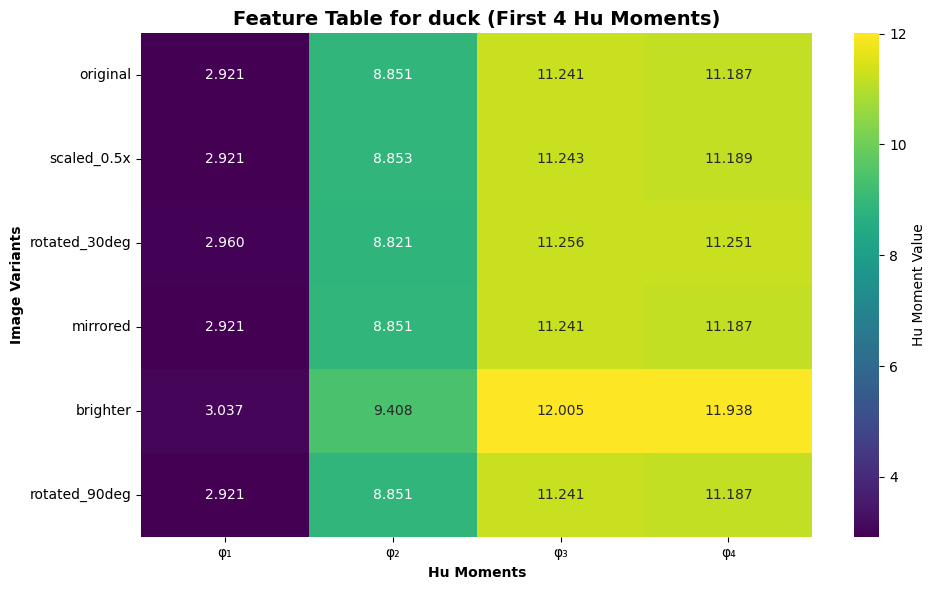

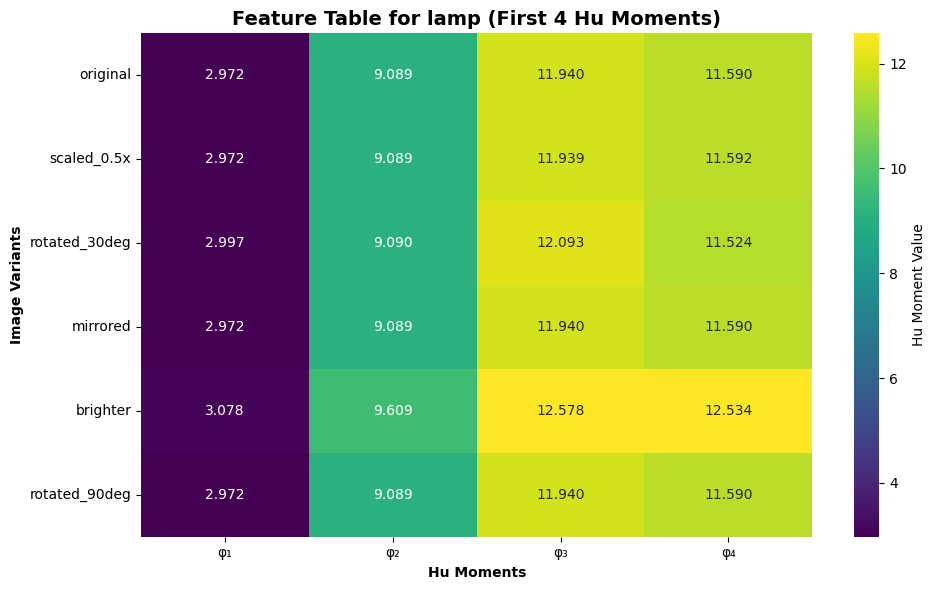

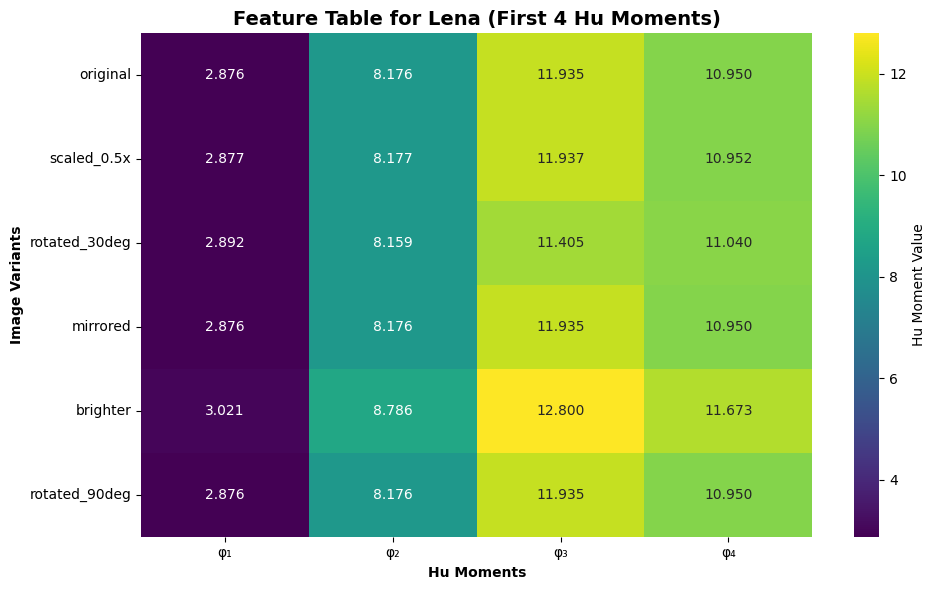

In [7]:
all_feature_vectors = {}
for name, path in all_variants.items():
    all_feature_vectors[name] = calculate_hu_moments(path)

base_names = [os.path.splitext(os.path.basename(path))[0] for path in base_image_paths]

for base_name in base_names:
    relevant_variants = {
        name: features 
        for name, features in all_feature_vectors.items() 
        if base_name in name
    }

    df = pd.DataFrame.from_dict(
        relevant_variants, 
        orient='index', 
        columns=['φ₁', 'φ₂', 'φ₃', 'φ₄']
    )
    
    variant_order = [
        f'{base_name}_original',
        f'{base_name}_scaled_0.5x',
        f'{base_name}_rotated_30deg',
        f'{base_name}_mirrored',
        f'{base_name}_brighter',
        f'{base_name}_rotated_90deg'
    ]
    
    variant_order = [v for v in variant_order if v in df.index]
    df = df.reindex(variant_order)
    
    df.index = [idx.replace(f'{base_name}_', '') for idx in df.index]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(df, annot=True, fmt='.3f', cmap='viridis', ax=ax, 
                cbar_kws={'label': 'Hu Moment Value'})
    ax.set_title(f'Feature Table for {base_name} (First 4 Hu Moments)', 
                 fontweight='bold', fontsize=14)
    ax.set_xlabel('Hu Moments', fontweight='bold')
    ax.set_ylabel('Image Variants', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    


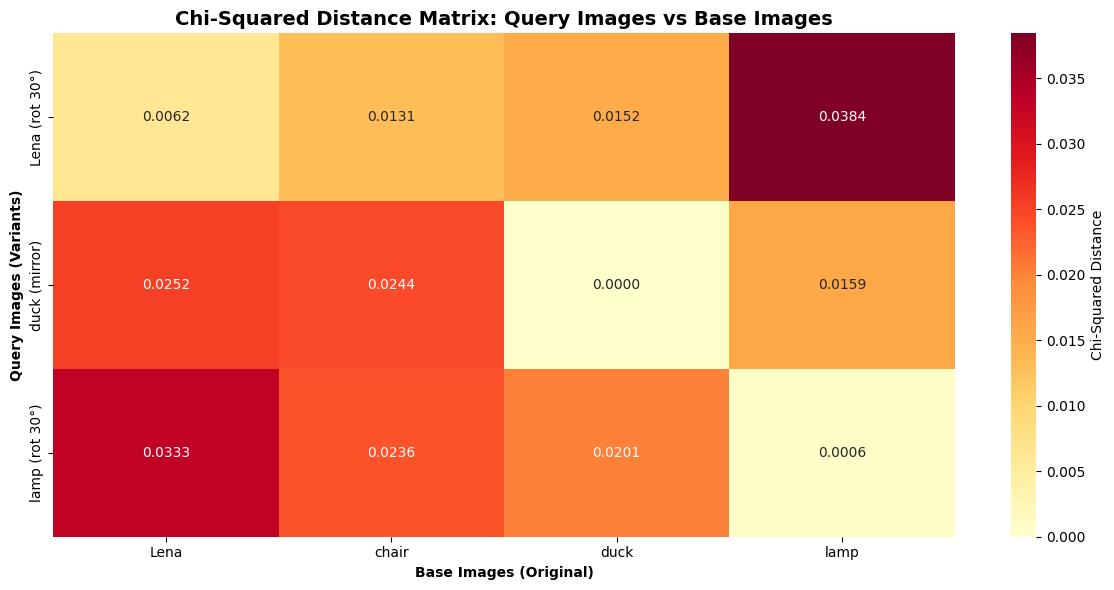

In [14]:
import random

base_image_features = {}
for base_name in base_names:
    orig_key = f'{base_name}_original'
    if orig_key in all_feature_vectors:
        base_image_features[base_name] = all_feature_vectors[orig_key]


query_images = []
query_labels = []
selected_bases = random.sample(base_names, min(3, len(base_names)))

for base_name in selected_bases:
    query_variants = ['rotated_30deg', 'mirrored']
    variant = random.choice(query_variants)
    
    query_key = f'{base_name}_{variant}'
    if query_key in all_feature_vectors:
        query_images.append(all_feature_vectors[query_key])
        query_labels.append(f'{base_name}_{variant}')

        
distance_matrix = []
for query_vec in query_images:
    distances = []
    for base_name in sorted(base_image_features.keys()):
        base_vec = base_image_features[base_name]
        dist = chi_squared_distance(query_vec, base_vec)
        distances.append(dist)
    distance_matrix.append(distances)

df_distances = pd.DataFrame(
    distance_matrix,
    index=query_labels,
    columns=sorted(base_image_features.keys())
)

df_distances.index = [label.replace('_scaled_0.5x', ' (0.5x)')
                              .replace('_rotated_30deg', ' (rot 30°)')
                              .replace('_mirrored', ' (mirror)') 
                      for label in df_distances.index]

fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(df_distances, annot=True, fmt='.4f', cmap='YlOrRd', ax=ax, 
            cbar_kws={'label': 'Chi-Squared Distance'})
ax.set_title('Chi-Squared Distance Matrix: Query Images vs Base Images', 
             fontweight='bold', fontsize=14)
ax.set_xlabel('Base Images (Original)', fontweight='bold')
ax.set_ylabel('Query Images (Variants)', fontweight='bold')

plt.tight_layout()
plt.show()


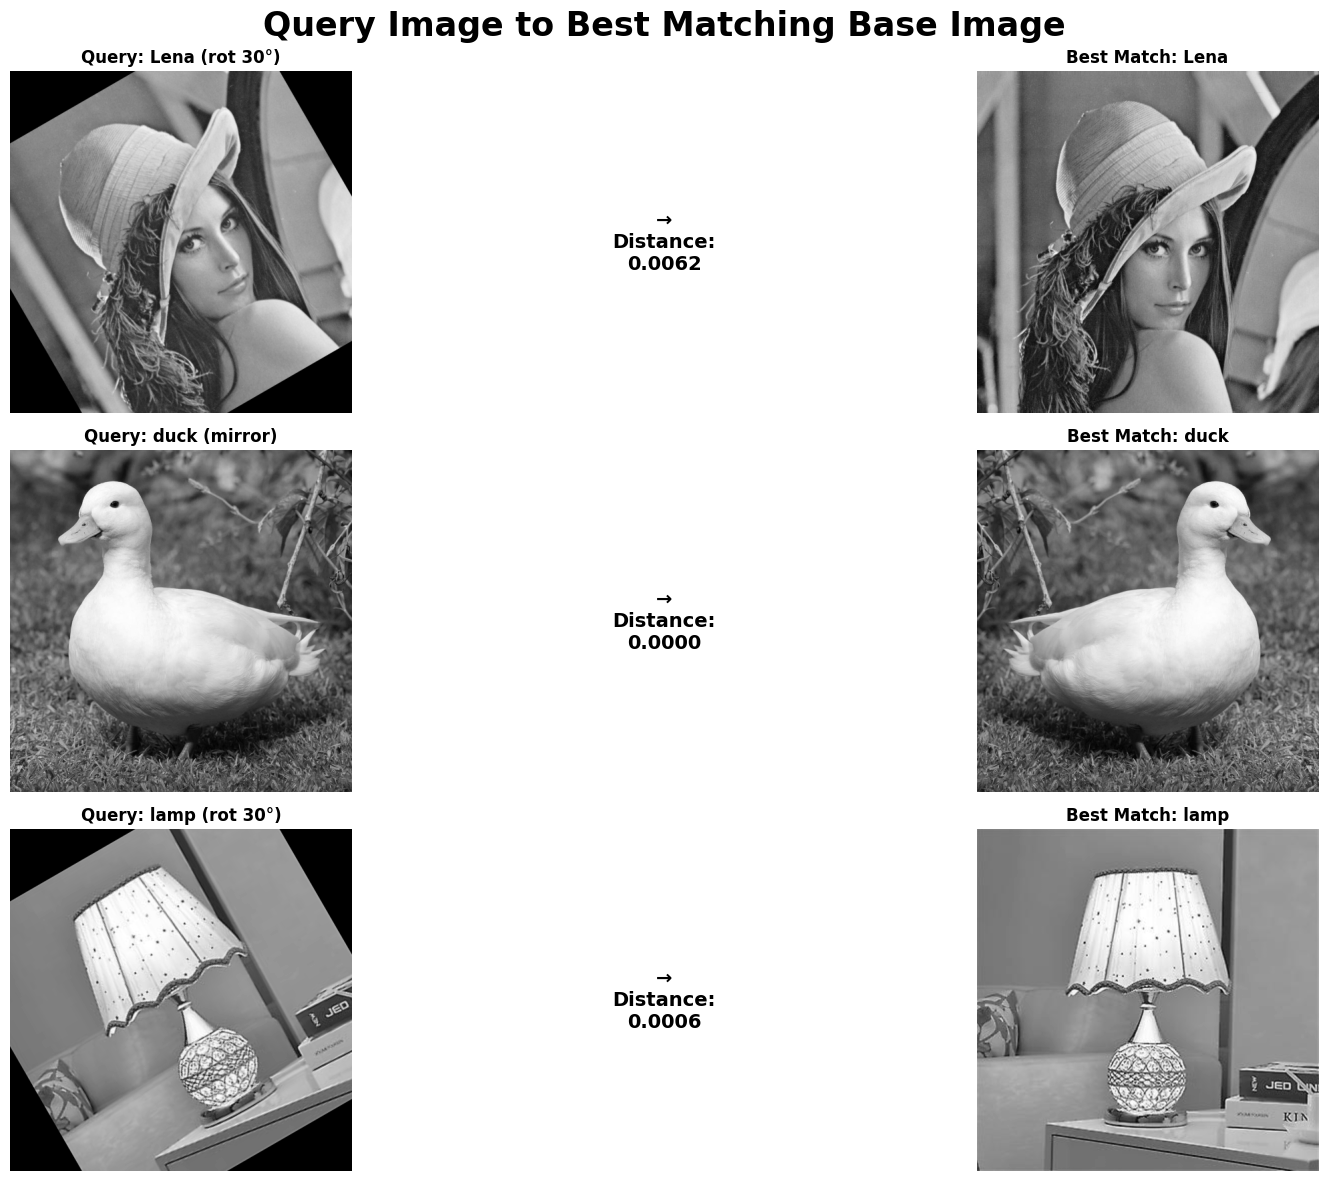

In [15]:
fig, axes = plt.subplots(len(query_images), 3, figsize=(15, len(query_images)*4))

if len(query_images) == 1:
    axes = axes.reshape(1, -1)

for i, query_label in enumerate(df_distances.index):
    min_idx = df_distances.iloc[i].argmin()
    best_match = df_distances.columns[min_idx]
    min_dist = df_distances.iloc[i].min()
    
    original_query_label = query_labels[i]

    query_path = all_variants[original_query_label]
    query_img = cv2.imread(query_path, cv2.IMREAD_GRAYSCALE)
    
    best_match_key = f'{best_match}_original'
    best_match_path = all_variants[best_match_key]
    best_match_img = cv2.imread(best_match_path, cv2.IMREAD_GRAYSCALE)

    if query_img.shape != best_match_img.shape:
       best_match_img_display = cv2.resize(best_match_img, 
                                           (query_img.shape[1], query_img.shape[0]))
    else:
        best_match_img_display = best_match_img
    
    axes[i, 0].imshow(query_img, cmap='gray')
    axes[i, 0].set_title(f'Query: {query_label}', fontweight='bold')
    axes[i, 0].axis('off')
    
    axes[i, 1].text(0.5, 0.5, f'→\nDistance:\n{min_dist:.4f}', 
                   ha='center', va='center', fontsize=14, fontweight='bold')
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(best_match_img, cmap='gray')
    axes[i, 2].set_title(f'Best Match: {best_match}', fontweight='bold')
    axes[i, 2].axis('off')

plt.suptitle('Query Image to Best Matching Base Image', fontsize=24, fontweight='bold')
plt.tight_layout()
plt.show()